In [3]:
""" from google.colab import drive
drive.mount('/content/gdrive') """

Mounted at /content/gdrive


In [4]:
""" %cd gdrive/MyDrive/FGMDA/pedestrians_recognition """

/content/gdrive/MyDrive/FGMDA/pedestrians_recognition


In [1]:
""" !pip install gudhi """

     |████████████████████████████████| 28.1MB 149kB/s 


In [5]:
import numpy as np
import pickle as pickle
import gudhi as gd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import MDS

# 1. The data

In [7]:
f = open("data/data_acc_rot.dat","rb")
data = pickle.load(f,encoding="latin1")
f.close()

data_A = np.array(data[0])
data_B = np.array(data[1])
data_C = np.array(data[2])
label = np.array(data[3])

time_serie = data_A[0,:,:]
print(time_serie.shape)

(200, 3)


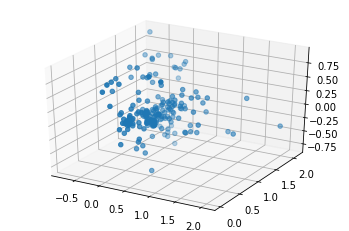

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(time_serie[:, 0], time_serie[:, 1], time_serie[:, 2]);

# 2. Persistance diagrams

In [9]:
max_edge_length = 0.2
skeleton = gd.RipsComplex(points=time_serie, max_edge_length=max_edge_length)
simplex_tree = skeleton.create_simplex_tree(max_dimension=2)

In [10]:
# rips_generator = simplex_tree.get_filtration()
simplex_tree.persistence()
rips_barcodes_0 = simplex_tree.persistence_intervals_in_dimension(0)
rips_barcodes_1 = simplex_tree.persistence_intervals_in_dimension(1)

In [ ]:
rips_barcodes_2[-10:]

NameError: name 'rips_barcodes_2' is not defined

usetex mode requires TeX.


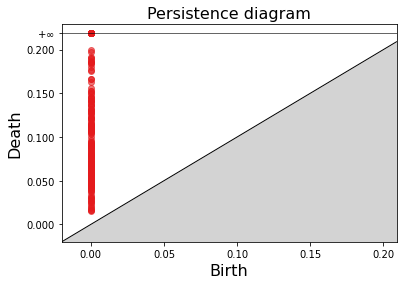

In [11]:
gd.plot_persistence_diagram(rips_barcodes_0)

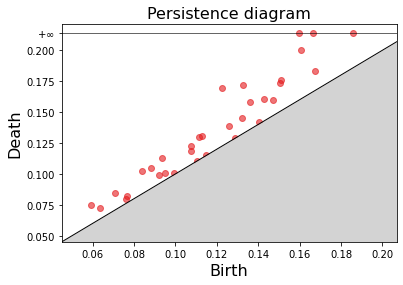

In [12]:
gd.plot_persistence_diagram(rips_barcodes_1)

# 3. Pairwise bottleneck distance

In [139]:
f = open("data/persistence_diagrams_0.8.dat","rb")
data = pickle.load(f)
f.close()

In [14]:
def get_pairwise_bottleneck_distance_matrix(persistence_diagrams):
    distance_matrix = np.zeros((300,300))
    for i, pd1 in enumerate(tqdm(persistence_diagrams)):
        for j, pd2 in enumerate(persistence_diagrams[i+1:], i+1):
            
            distance_matrix[i,j] = distance_matrix[j,i] = gd.bottleneck_distance(pd1,pd2)
    
    return distance_matrix

distance_matrix_0, distance_matrix_1 = list(map(get_pairwise_bottleneck_distance_matrix, data))

100%|██████████| 300/300 [00:24<00:00, 12.06it/s]


In [ ]:
distance_matrix_1[0,:40]

array([0.        , 0.08186699, 0.06658741, 0.09018938, 0.09126953,
       0.08186699,        inf, 0.05788166, 0.08186699,        inf,
       0.08186699, 0.05623288, 0.08186699, 0.08186699, 0.06883524,
              inf, 0.08186699, 0.08186699, 0.04475686, 0.06564203,
       0.05424153, 0.07133855, 0.0658374 , 0.04974124, 0.07984351,
       0.08186699,        inf, 0.08186699, 0.04030701, 0.05985773,
              inf, 0.02579894, 0.05424153, 0.07739581, 0.04423793,
       0.05461536, 0.07423133, 0.06710561, 0.05869551, 0.06921787])

In [ ]:
correction = np.copy(distance_matrix_1)
for i in range(300):
    for j in range(300):
        if distance_matrix_1[i,j] == np.inf:
            correction[i,j] = 1

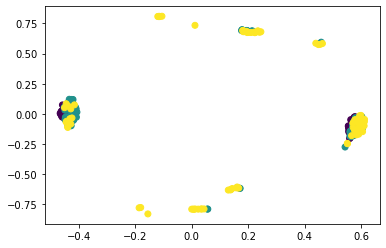

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed')
projection = mds.fit_transform(correction)

plt.scatter(projection[:,0], projection[:,1], c=[0]*100+[1]*100+[2]*100)
plt.savefig("data/test.jpg")

# 4. Landscapes
* https://gudhi.inria.fr/doc/3.1.1/group___persistence__representations.html gudhi library qui le fait peut-être

* http://www-sop.inria.fr/teams/abs/teaching/centrale-FGMDA/slides_mathieu/class7%20-%202.pdf slide 55, le cours qui explique

In [39]:
from gudhi.representations import Landscape

Simple example

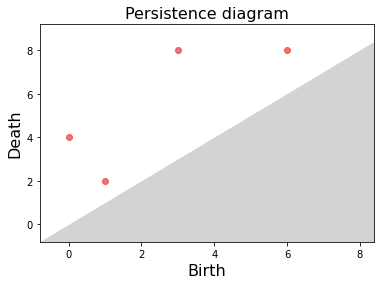

In [29]:
D = np.array([[0.,4.],[1.,2.],[3.,8.],[6.,8.]])
gd.plot_persistence_diagram(D)
l=Landscape(num_landscapes=2,resolution=10).fit_transform([D]).reshape((2, 10))
print(l)

Main function

In [55]:
def compute_persistence_landscape(pers_d, xmin = np.nan, xmax= np.nan, nbnodes=100, nbld=5):
    landscape = np.zeros((len(pers_d), nbnodes*nbld))
    for i, pd_ in enumerate(tqdm(pers_d)):
        landscape[i,:] = Landscape(num_landscapes=nbld,resolution=nbnodes, sample_range=[xmin, xmax]).fit_transform([pd_])
    return landscape

# 5. Landscapes classification



In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [134]:
def evaluate_model_pd(clf, X_train, y_train, X_test, y_test, k = [0]):
     ''' 
    clf : a classifier from sklearn with fit and predict methods
    k : dimension of persitence diagram to use for classification, [0,1] for both 
    '''
    assert 0 in k or 1 in k, "invalid dimension"
    start = 0
    end = X_train.shape[1]
    if 0 not in k :
      start = end // 2
    elif 1 not in k:
      end = end // 2
    clf.fit(X_train[:, start:end], y_train)

    preds = clf.predict(X_test[:, start:end])
    acc = accuracy_score(y_test, preds)
    return round(acc*100,1)


First test

In [81]:
nbnodes = 200
ld = np.concatenate(list(map(lambda p:compute_persistence_landscape(p, xmin=0, xmax=1, nbnodes=nbnodes, nbld=5), data)), axis = 1)
label = [0]*100+[1]*100+[2]*100

ld_train, ld_test, y_train, y_test = train_test_split(ld, label, train_size=0.8, random_state=42)

clf = RandomForestClassifier(random_state=42)
evaluate_model_pd(clf, ld_train, y_train, ld_test, y_test, k = [0,1])

Fine tuning and comparaison

In [140]:
def compare_model(data, nbnodes=[100], n_estimators = [100], dim_used=[[0],[1],[0,1]]):
    acc = np.zeros((len(nbnodes), len(n_estimators), len(dim_used)))
    for i, nbn in enumerate(nbnodes):
        ld = np.concatenate(list(map(lambda p:compute_persistence_landscape(p, xmin=0, xmax=1, nbnodes=nbn, nbld=5), data)), axis = 1)
        label = [0]*100+[1]*100+[2]*100
        ld_train, ld_test, y_train, y_test = train_test_split(ld, label, train_size=0.8, random_state=42)

        for j, ne in enumerate(n_estimators):
            clf = RandomForestClassifier(n_estimators=ne, random_state=42)

            for l, k in enumerate(dim_used):
                acc[i,j,l] = evaluate_model_pd(clf, ld_train, y_train, ld_test, y_test, k = k)

    return acc
  

In [ ]:
nbnodes_tested = [50, 80, 100, 150, 200]
n_estimators_tested = [50, 100, 150, 200]
acc = compare_model(data, nbnodes = nbnodes_tested, n_estimators = n_estimators_tested)

In [156]:
def plot_heatmap(data, label_xaxis, label_yaxis, x_tick, y_tick):
    fig, ax = plt.subplots()
    im = ax.imshow(data)
    ax.set_xticks(np.arange(len(x_tick)))
    ax.set_yticks(np.arange(len(y_tick)))
    ax.set_xticklabels(x_tick)
    ax.set_yticklabels(y_tick)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    for i in range(len(y_tick)):
          for j in range(len(x_tick)):
              text = ax.text(j, i, data[i, j],
                            ha="center", va="center", color="w")
            
    ax.set_xlabel(label_xaxis)
    ax.set_ylabel(label_yaxis)

    ax.set_title("Accuracy comparaison")
    fig.tight_layout()
    plt.show(fig)

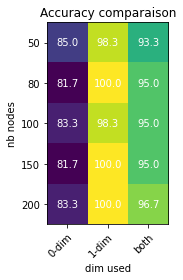

In [150]:
plot_heatmap(acc[:,1,:], "dim used", "nb nodes",["0-dim", "1-dim", "both"], nbnodes_tested)

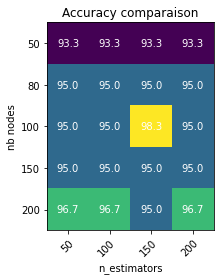

In [159]:
plot_heatmap(acc[:,:,2], "n_estimators", "nb nodes",n_estimators_tested, nbnodes_tested)

# 6. Raw data classification

Load and split it

In [161]:
f = open("data/data_acc_rot.dat","rb")
data = pickle.load(f,encoding="latin1")
f.close()

X = np.concatenate(data[:3], axis=0).reshape(300,600)
y = np.array(data[3])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)



Fit and evaluate random forest with the raw data

In [165]:
min_samples_split_tested = [2,3,4,5]
n_estimators_tested = [50, 100, 150, 200]
acc_raw = np.zeros((len(n_estimators_tested), len(min_samples_split_tested)))

for i, ne in enumerate(n_estimators_tested):
    for j, ms in enumerate(min_samples_split_tested):
        clf = RandomForestClassifier(n_estimators = ne, min_samples_split = ms, random_state=42)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        acc_raw[i,j] = round(accuracy_score(y_test, preds)*100,1)



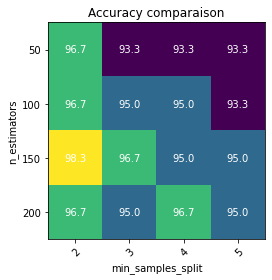

In [166]:
plot_heatmap(acc_raw, "min_samples_split", "n_estimators",min_samples_split_tested, n_estimators_tested)